In [ ]:
"""
We identify the PRNG use by default for machine learning technologies.
Numpy : https://numpy.org/doc/stable/reference/random/bit_generators/philox.html (use PCG64 by default)

Python : https://docs.python.org/3/library/random.html (use Mersenne Twister by default)

Tensorflow : https://www.tensorflow.org/api_docs/python/tf/random/Generator  (Philox and ThreeFry, but without much information)

PyTorch : torchcsprng based on Philox ? Not sure : 
https://pytorch.org/docs/stable/generated/torch.Generator.html  
https://pytorch.org/docs/stable/torch.html#in-place-random-sampling
https://pytorch.org/blog/torchcsprng-release-blog

Scipy : Based on Numpy
Scikit-learn : Based on Numpy
…

"""


In [ ]:
"""
First, we run native experiments.
Native experiments are C codes of MT, Well, MRG32k3a and PCG64 (XSL-RR).

For each, we generate 2**30 real (0,1) random numbers.
We compile with nothing + O2 + O3, to check for performance increase.

We run 30 times each experiments to draw a confidence interval.

We measure time and energy consumption (with Powerjoular : https://gitlab.com/joular/powerjoular)

This will not take much time as C code versions are fast to generate 2**30 numbers.

Powerjoular needs SUDO

"""
!sudo ./scriptRunNativeExperiment.sh

In [ ]:
"""
Secondly, we run python experiments. (Python is the main langage used in ML)
We work on pure Python, Numpy, Tensorflow and Pytorch.

For each, we generate 2**30 real (0,1) random numbers.

We run 30 times each experiments to draw a confidence interval.

We measure time and energy consumption (with Powerjoular : https://gitlab.com/joular/powerjoular)

This will take much times.

Indeed, to generate numbers one by one, Python frameworks are really slow.
For small operations, like generating a single random number, 
the overhead of using TensorFlow or PyTorch can be high. 
However, these libraries aren't really designed for such small, isolated operations. 
They are made to work in large-scale, batched operations.

To respect initial usage and compare fairly,
we made 2 different types of experiments here: Generating 2**30 prn one by one, or at once.

Powerjoular needs SUDO

"""
!sudo ./scriptRunPythonExperiment.sh

In [ ]:
"""
Thridly, after comparing time execution and power consumption,
we want to check for numerical reproducibility, as well as PRN quality (using TestU01 big Crush).

To do so, on python code, we have to save number in file before applying Big Crush on these numbers.
Maybe it could have been possible to create a link between output of Python function and output of C function.

As TestU01 do not provide a file reading access for Big Crush, we did it ourselves.

WARNING : 
Big Crush uses close to 2**38 numbers. You will have to generate and save them in a binary file.
This will take much disk space (around 2.1T by binary file).

"""
!./scriptRunSaving.sh

In [ ]:
"""
To be sure that Big Crush on the original usage and Big Crush when reading file give the same results,
we made 3 experiment to have original Big Crush results on Mrg32k3a, Well and MT.

We will be able to compare when reading in files.
"""
!./scriptRunControlBigCrush.sh

In [ ]:
"""
We test the quality of generated PRN for all technologies, native or Python, with Big Crush
"""
!./scriptRunBigCrushTestsOnBinary.sh

###numpyTaskset_numpyTasksetRandomGenerationAtOnce
###mt19937arO2
###pytorchR_pytorchRandomGenerationOneByOne
###pcg64R
###mt19937arR
###well19937aR
###well19937O2a
###numpyR_numpyRandomGenerationOneByOne
###pythonTaskset_pythonTasksetRandomGenerationAtOnce
###pythonR_pythonRandomGenerationOneByOne
###numpyPhilox_numpyPhiloxRandomGenerationOneByOne
###numpyPhilox_numpyPhiloxRandomGenerationAtOnce
###pytorchTaskset_pytorchTasksetRandomGenerationAtOnce
###numpyMt_numpyMtRandomGenerationAtOnce
###well19937O3a
###pytorchR_pytorchRandomGenerationAtOnce
###numpyMt_numpyMtRandomGenerationOneByOne
###mt19937arO3
###tensorflowTaskset_tensorflowTasksetRandomGenerationAtOnce
###pcg64O3
###pythonR_pythonRandomGenerationAtOnce
###pcg64O2
###mrg32k3aR
###mrg32k3aO3
###mrg32k3aO2
###numpyR_numpyRandomGenerationAtOnce
###tensorflowR_tensorflowRandomGenerationAtOnce
Average Real time for mrg32k3aO2: 31.47 seconds, Std Dev: 0.70, 95% Confidence Interval: [31.21; 31.72]
Average Real time for mrg32k3aO3: 

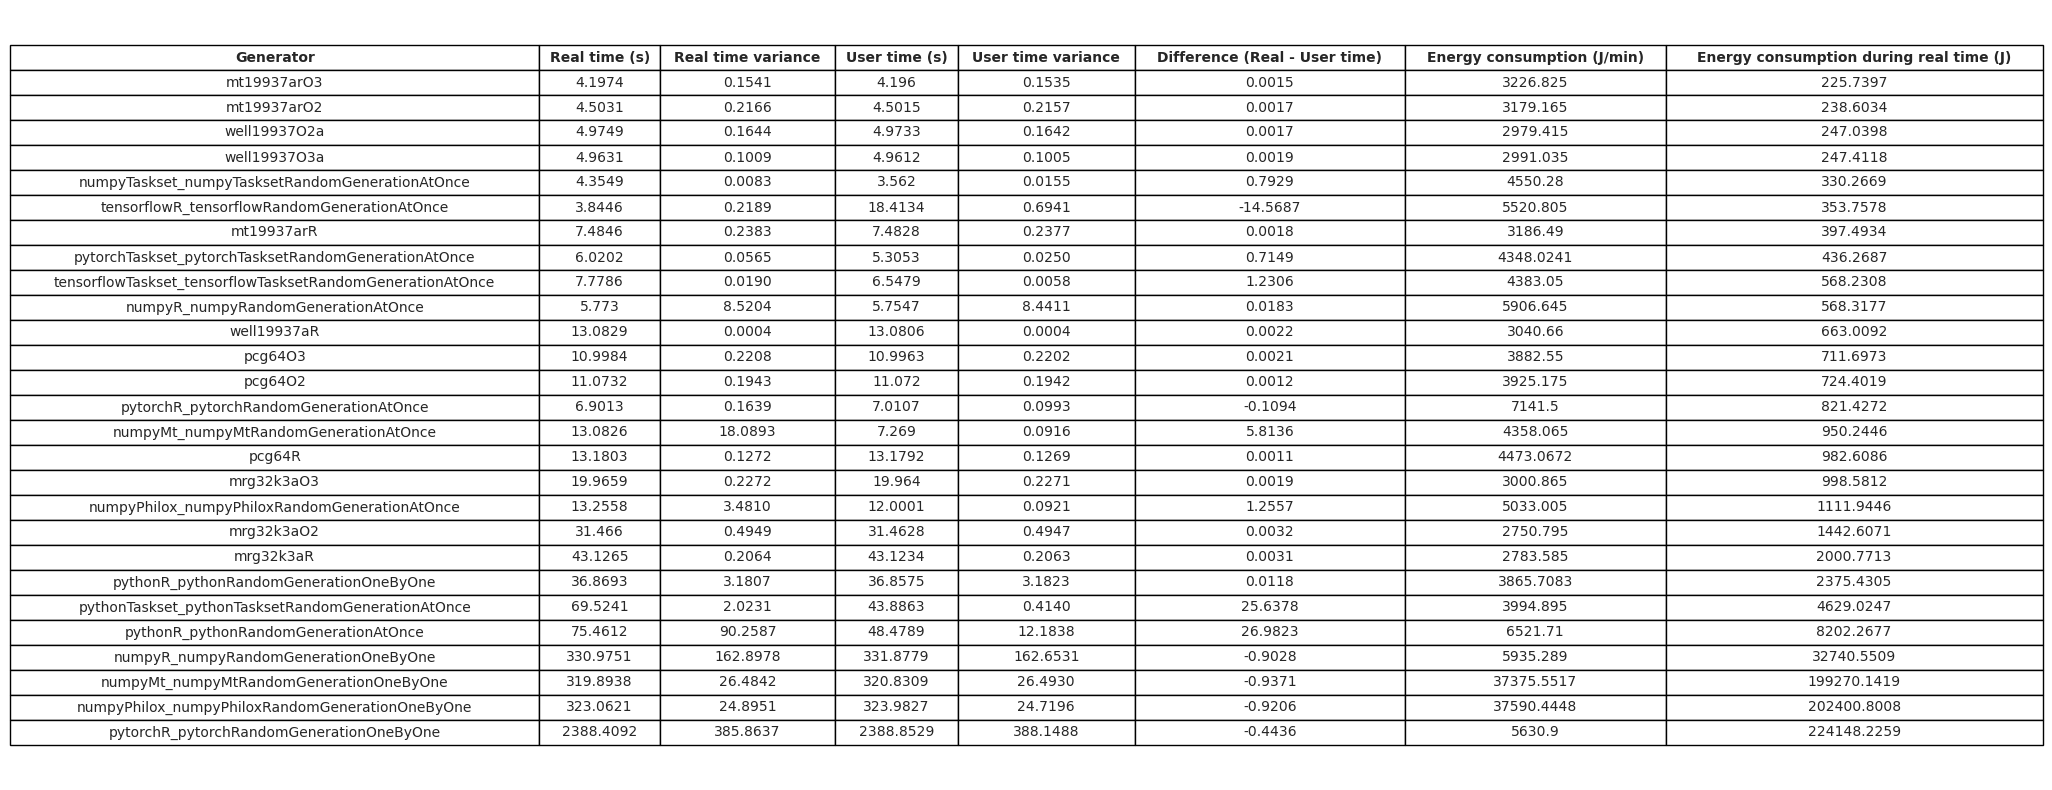

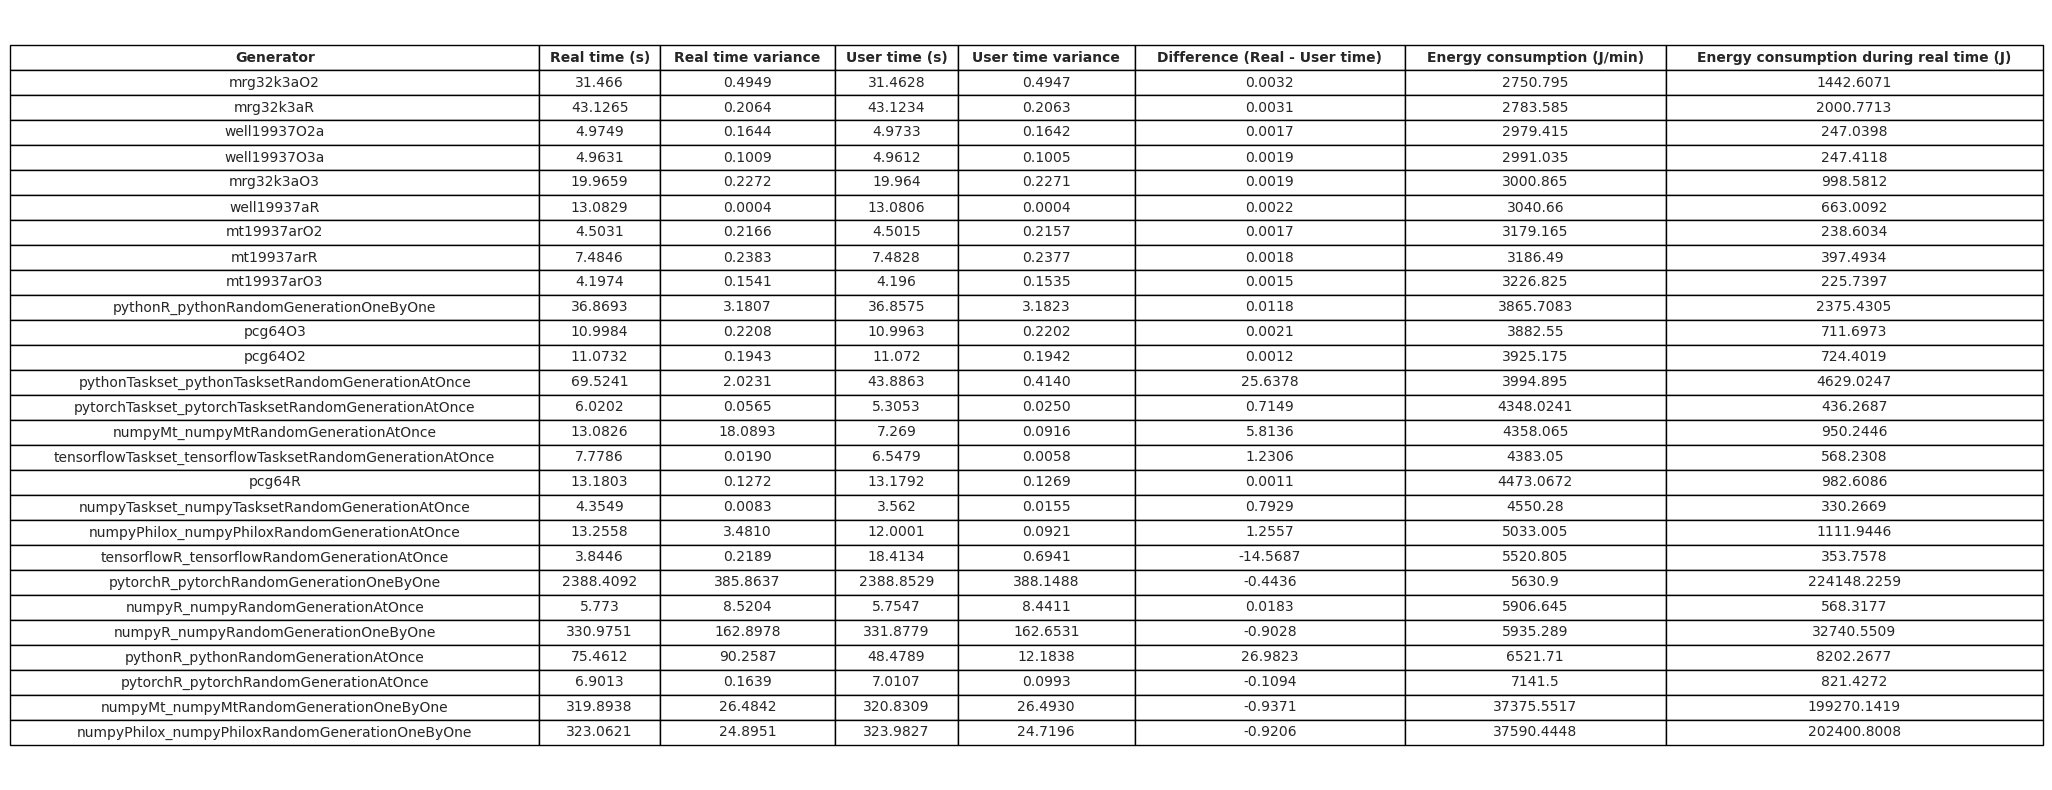

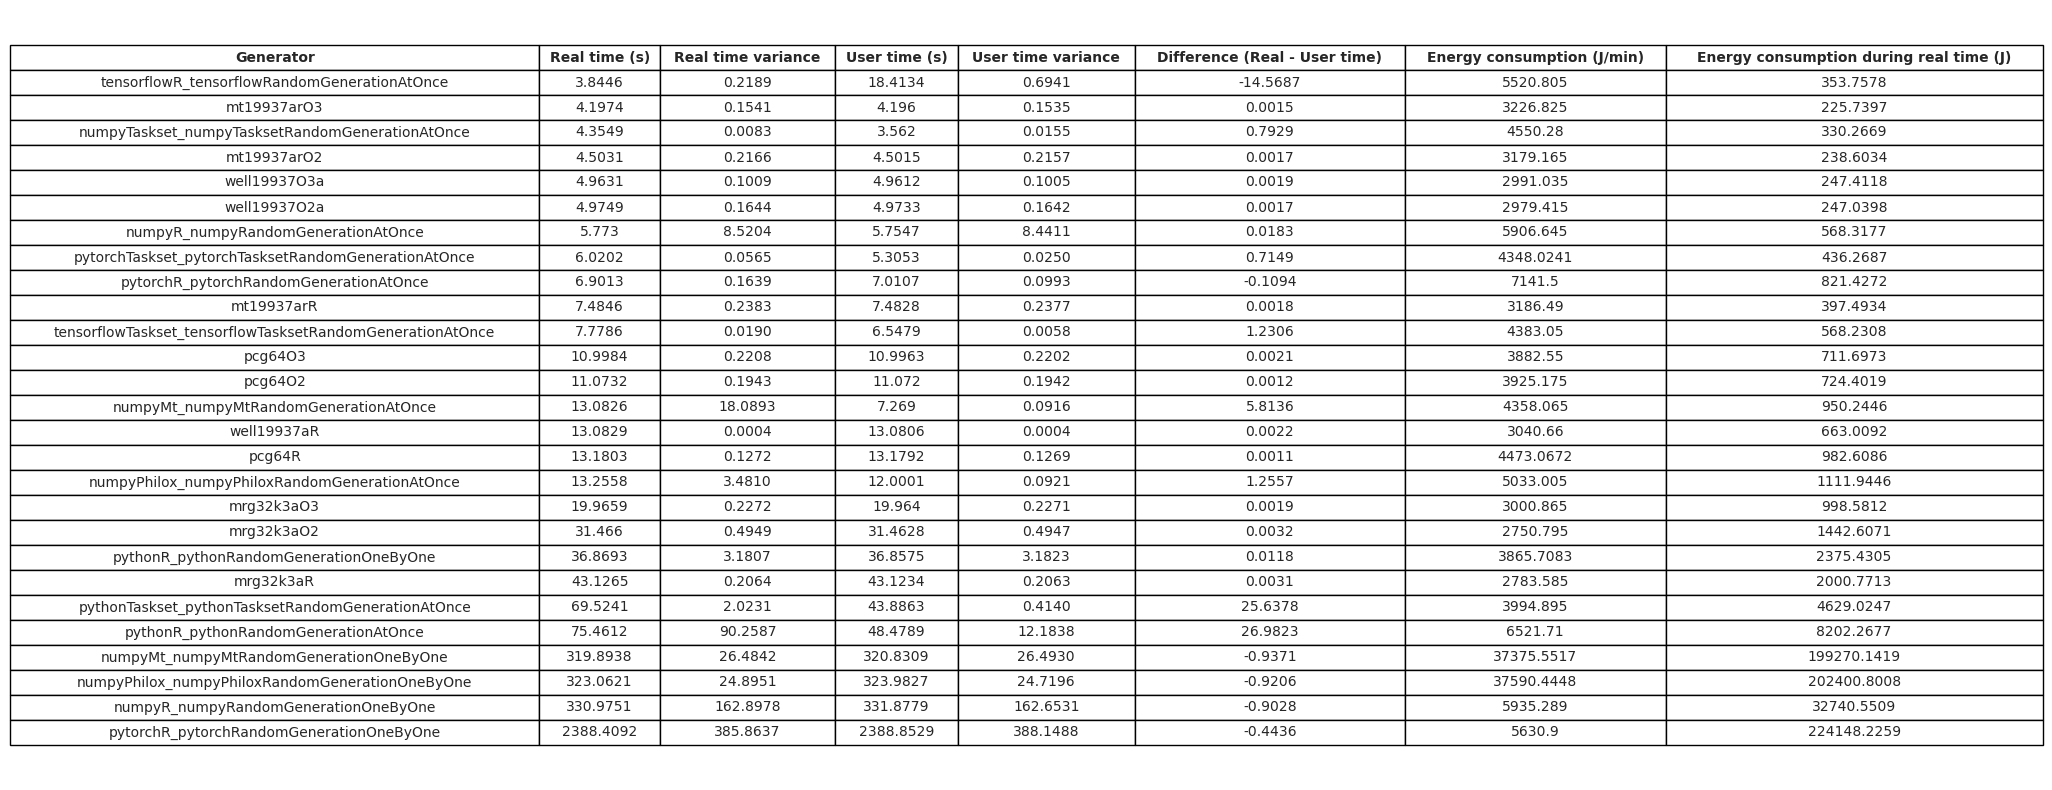

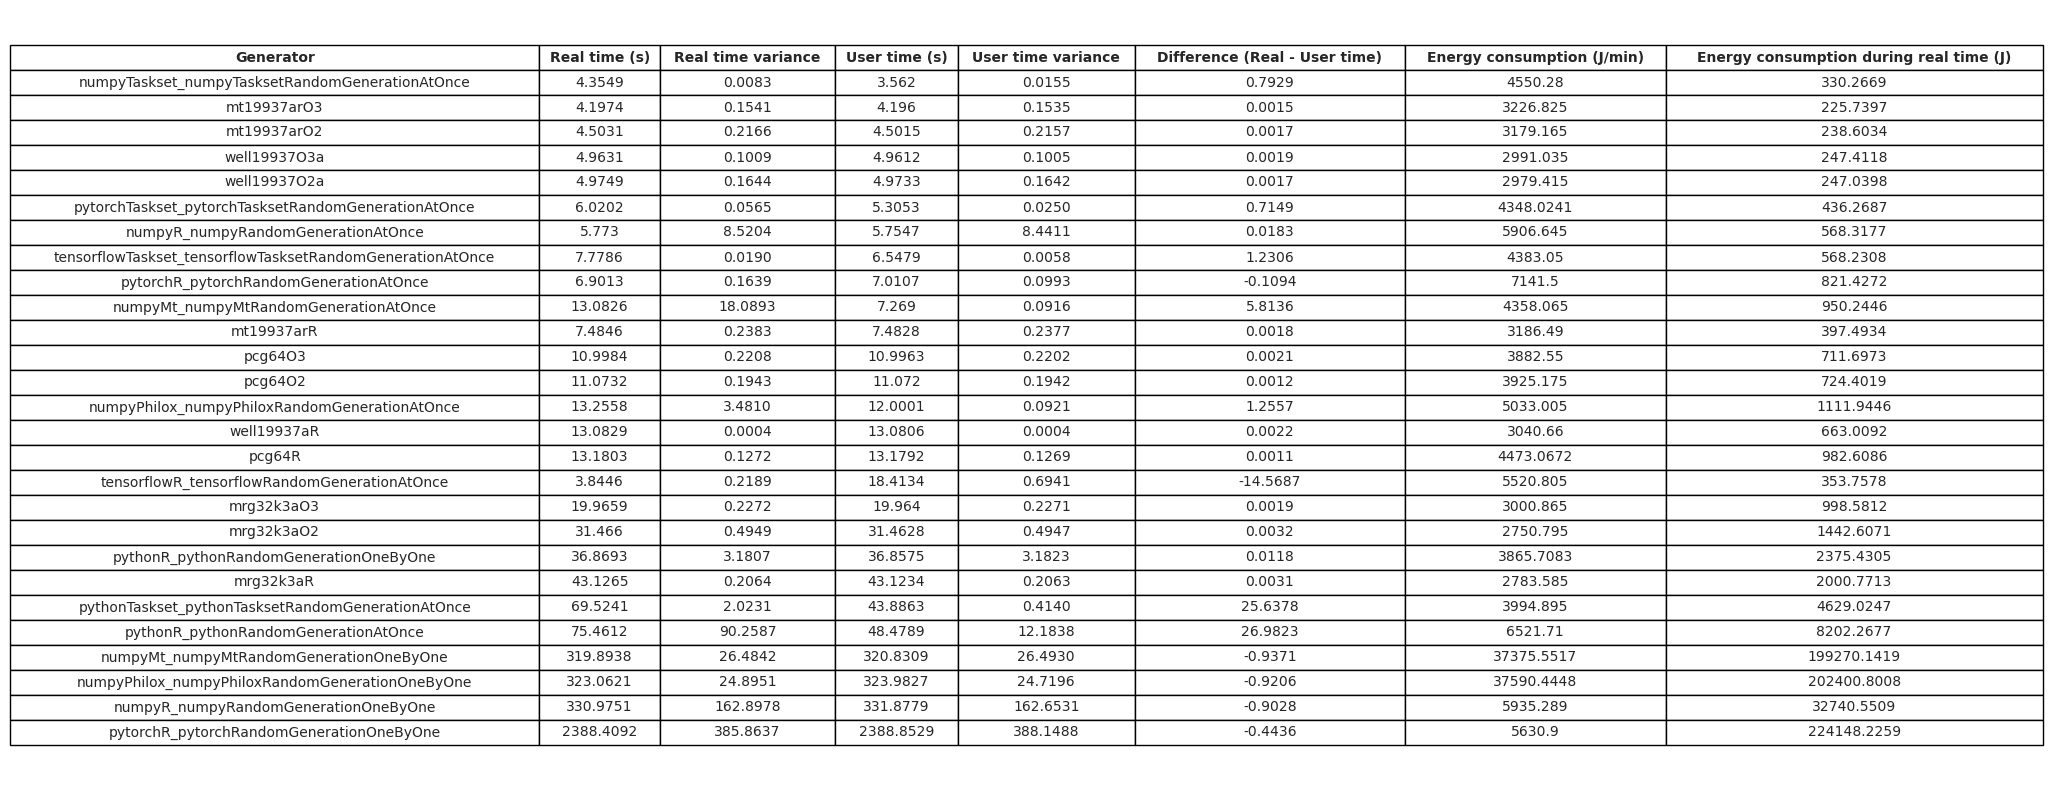

In [27]:
"""
Now, every results should be accessible.
We need to analyze those results.

Diff python vs Mt binary ? diff Numpy vs Pcg binary ?
"""
import os
import re
import statistics
import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns

# List of experiments
names = ["mrg32k3aR", "mrg32k3aO2", "mrg32k3aO3", "well19937aR", "well19937O2a", "well19937O3a", "mt19937arR",
         "mt19937arO2", "mt19937arO3", "pcg64R", "pcg64O2", "pcg64O3", "pythonR", "pytorchR", "tensorflowR", "numpyR",
        "pythonTaskset", "pytorchTaskset","tensorflowTaskset","numpyTaskset","numpyPhilox", "numpyMt"]


## TIMES : 


# Separate dictionaries for storing real and user times
real_times_dict = {}
user_times_dict = {}

# Function to extract user times and compute their average
def extract_times(contents):
    user_times = [int(minute) * 60 + float(second.replace(',', '.')) for minute, second in re.findall(r'user\s+(\d+)m([\d,]+)s', contents)]
    real_times = [int(minute) * 60 + float(second.replace(',', '.')) for minute, second in re.findall(r'real\s+(\d+)m([\d,]+)s', contents)]
    return real_times, user_times

# Loop through each file in the directory
for filename in os.listdir('.'):
    # Check if the filename starts with "time_results_"
    if filename.startswith("time_results_"):
        for name in names:
            if name in filename:
                if name in ["pythonR","numpyPhilox","numpyMt","pytorchR", "numpyR", "tensorflowR","pythonTaskset", "pytorchTaskset","tensorflowTaskset","numpyTaskset"] and ("OneByOne" in filename or "AtOnce" in filename):
                    key_name = f"{name}_{filename.split('_')[-1].split('.')[0]}" # Appends OneByOne or AtOnce to the name
                else:
                    key_name = name
                
                with open(filename, 'r') as file:
                    contents = file.read()
                    real_times, user_times = extract_times(contents)
                    if user_times:
                        print("###" + str(key_name))
                        avg_time = sum(user_times) / len(user_times)
                        user_times_dict[key_name] = avg_time
                        stdev_time = statistics.stdev(user_times)
                        # 95% confidence interval
                        margin_of_error = 1.96 * (stdev_time / (len(user_times) ** 0.5))
                        lower_bound = avg_time - margin_of_error
                        upper_bound = avg_time + margin_of_error
                        user_times_dict[key_name] = (avg_time, stdev_time, (lower_bound, upper_bound))

                    if real_times:
                        avg_time = sum(real_times) / len(real_times)
                        real_times_dict[key_name] = avg_time
                        stdev_time = statistics.stdev(real_times)
                        # 95% confidence interval
                        margin_of_error = 1.96 * (stdev_time / (len(real_times) ** 0.5))
                        lower_bound = avg_time - margin_of_error
                        upper_bound = avg_time + margin_of_error
                        real_times_dict[key_name] = (avg_time, stdev_time, (lower_bound, upper_bound))


# Print the results in alphabetical order by key
for key in sorted(real_times_dict.keys()):
    avg, stdev, (lower, upper) = real_times_dict[key]
    print(f"Average Real time for {key}: {avg:.2f} seconds, Std Dev: {stdev:.2f}, 95% Confidence Interval: [{lower:.2f}; {upper:.2f}]")

# Print the results in alphabetical order by key
for key in sorted(user_times_dict.keys()):
    avg, stdev, (lower, upper) = user_times_dict[key]
    print(f"Average User time for {key}: {avg:.2f} seconds, Std Dev: {stdev:.2f}, 95% Confidence Interval: [{lower:.2f}; {upper:.2f}]")

        
    
print("#############") 
print("#############") 
print("#############") 
print("#############") 
    
##### POWER : 

    
# Dictionary to store the average user consumption and other statistics for each experiment
average_consumption = {}

# Function to extract energy consumptions
def extract_consumptions(contents):
    energy_consumptions = [float(energy) for energy in re.findall(r'Total energy: ([\d.]+) Joules', contents)]
    return energy_consumptions

# Loop through each file in the directory
for filename in os.listdir('.'):
    # Check if the filename starts with "power_results_"
    if filename.startswith("power_results_"):
        for name in names:
            if name in filename:
                if name in ["pythonR","numpyPhilox","numpyMt","pytorchR", "numpyR", "tensorflowR","pythonTaskset", "pytorchTaskset","tensorflowTaskset","numpyTaskset"] and ("OneByOne" in filename or "AtOnce" in filename):
                    key_name = f"{name}_{filename.split('_')[-1].split('.')[0]}" # Appends OneByOne or AtOnce to the name
                else:
                    key_name = name
                
                with open(filename, 'r') as file:
                    contents = file.read()
                    consumptions = extract_consumptions(contents)
                    if consumptions:
                        avg_energy = sum(consumptions) / len(consumptions)
                        stdev_energy = statistics.stdev(consumptions)
                        # 95% confidence interval
                        margin_of_error = 1.96 * (stdev_energy / (len(consumptions) ** 0.5))
                        lower_bound = avg_energy - margin_of_error
                        upper_bound = avg_energy + margin_of_error
                        multiplier = 2 if (("pythonR" in key_name or "pytorchR" in key_name or "numpyR" in key_name or "tensorflowR" in key_name) and "OneByOne" in key_name)  else 15
                        average_consumption[key_name] = (avg_energy * multiplier, stdev_energy * multiplier, (lower_bound * multiplier, upper_bound * multiplier))

# Print the results in alphabetical order by key
for key in sorted(average_consumption.keys()):
    avg, stdev, (lower, upper) = average_consumption[key]
    print(f"Average energy consumption in Joules by minutes for {key}: {avg:.2f} Joules, Std Dev: {stdev:.2f}, 95% Confidence Interval: [{lower:.2f}; {upper:.2f}]")

# Create a new DataFrame
df = pd.DataFrame(columns=["Generator", "Real time (s)", "Real time variance", "User time (s)", "User time variance", "Difference (Real - User time)", "Energy consumption (J/min)", "Energy consumption during real time (J)"])

# Populate the DataFrame
for key in sorted(user_times_dict.keys()):
    real_time_avg, real_time_stdev, _ = real_times_dict.get(key, (0, 0, (0, 0)))
    user_time_avg, user_time_stdev, _ = user_times_dict.get(key, (0, 0, (0, 0)))
    
    real_time_variance = real_time_stdev ** 2  # Variance is the square of standard deviation
    user_time_variance = user_time_stdev ** 2
    
    difference_time = real_time_avg - user_time_avg
    
    avg_energy, _, _ = average_consumption.get(key, (0, 0, (0, 0)))
    energy_for_real_time = avg_energy * (real_time_avg / 60)  # Divide by 60 to convert to minutes

    df.loc[len(df)] = [key, real_time_avg, real_time_variance, user_time_avg, user_time_variance, difference_time, avg_energy, energy_for_real_time]

# Display the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv('results.csv', index=False)


# Format all float columns of the DataFrame to have 4 decimals
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].apply(lambda x: '{:.4f}'.format(x))



# Convert columns back to floats for plotting
df["Real time (s)"] = df["Real time (s)"].astype(float)
df["User time (s)"] = df["User time (s)"].astype(float)
df["Energy consumption (J/min)"] = df["Energy consumption (J/min)"].astype(float)
df["Energy consumption during real time (J)"] = df["Energy consumption during real time (J)"].astype(float)

# Function to display a dataframe as a table and save as an image
def display_and_save_table(df, filename):
    # Style setup
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(20, 10))  # set the size that you'd like (width, height)
    ax.axis('off')
    tab = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tab.auto_set_font_size(False)
    tab.set_fontsize(10)
    tab.scale(1.5, 1.5)   # Adjust the scaling factor to fit your entries
    for idx, width in col_width.items():
        tab.auto_set_column_width(idx)
    for (i, j), cell in tab.get_celld().items():
        if i == 0:
            cell.set_text_props(fontweight='bold')
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

# Display the table sorted by "Energy consumption during real time (J)"
ordered_df = df.sort_values(by="Energy consumption during real time (J)", ascending=True)
display_and_save_table(ordered_df, 'table_sorted_by_energy_real_time.png')

# Display the table sorted by "Energy consumption (J/min)"
ordered_df = df.sort_values(by="Energy consumption (J/min)", ascending=True)
display_and_save_table(ordered_df, 'table_sorted_by_energy_per_minute.png')

# Display the table sorted by "Real time (s)"
ordered_df = df.sort_values(by="Real time (s)", ascending=True)
display_and_save_table(ordered_df, 'table_sorted_by_real_time.png')

# Display the table sorted by "User time (s)"
ordered_df = df.sort_values(by="User time (s)", ascending=True)
display_and_save_table(ordered_df, 'table_sorted_by_user_time.png')


In [ ]:
"""

To test numerical reproducibility of each PRNG technology, I can generate 2**20 random numbers, not as binary, and Diff files.
TestU01 is done on 2**38 binary.
"""